In [1]:
import torch
import os
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
from pathlib import Path

from torch.quasirandom import SobolEngine

from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.constraints import Interval

from botorch import fit_gpytorch_mll
from botorch.utils.transforms import unnormalize, normalize
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.acquisition import qLogExpectedImprovement
from botorch.sampling.stochastic_samplers import StochasticSampler

from helpers import (load_experiment_metadata, 
                    compute_nrmse_counts_all_edges, 
                    parse_loop_data_xml_to_pandas, 
                    create_taz_xml,
                    simulate_od,
                    od_xml_to_df,
                    xml2df_str)


In [2]:
!Pwd

/Users/chois/Gitsrcs/origin_destination_bayes_opt/bayesian_optimization


In [3]:
# base_path = "/home/bench/Gitsrcs/origin_destination_bayes_opt"
# base_path = "/Users/osorio/HEC/Research/Group/FacultyCollaborations/SeongjinChoi_UMN/Code_BO/origin_destination_bayes_opt-main"
base_path = "/Users/chois/Gitsrcs/origin_destination_bayes_opt"
os.chdir(base_path)

In [4]:
config_path = Path(base_path , 'config')
print(f"config_path: {config_path}")

config, sim_setup = load_experiment_metadata(config_path)

network_name = sim_setup['network_name']
model_name = sim_setup['model_name']

network_path = Path("network" , network_name)
taz2edge_xml = Path(base_path, network_path, 'taz.xml')
net_xml = Path(base_path, network_path, 'net.xml')
fixed_routes = Path(base_path, network_path, 'routes.csv')
file_gt_od = Path(base_path, network_path, 'od.xml')
additional_xml = Path(base_path, network_path, 'additional.xml')

out_path = f"output/{network_name}_{model_name}" 
Path(out_path).mkdir(parents=True, exist_ok=True)

gt_version_str = network_name           ## TODO : need to check if this is correct

EDGE_OUT_STR = f'edge_data_{network_name}.xml'
# suffix of simulation output edge file
TRIPS2ODS_OUT_STR = 'trips.xml'
SUMO_PATH = config["SUMO"]

sim_start_time = sim_setup['sim_start_time']
sim_end_time = sim_setup['sim_end_time']
sim_stat_freq_sec = sim_setup['sim_stat_freq_sec']
od_duration_sec = sim_setup['od_duration_sec']

n_init_search = sim_setup['n_init_search']

NITER = sim_setup["BO_niter"]
BATCH_SIZE = sim_setup["BO_batch_size"]
NUM_RESTARTS = sim_setup["BO_num_restarts"]
RAW_SAMPLES = sim_setup["BO_raw_samples"] 



config_path: /Users/chois/Gitsrcs/origin_destination_bayes_opt/config


In [5]:

# # taz2edge_xml = 'taz_new.xml'
# # net_xml = 'SFO.net.xml'
# # fixed_routes_xml = f'{base_path}/5hr_route_choice_set.csv'
# # od_duration_seconds = 5*60 

# # # duration of sample time for simulation output statistics
# # simulation_stat_freq_sec = od_duration_seconds
# # sim_end_time = od_duration_seconds
# # additional_xml = f'additional.add_statfreq{od_duration_seconds}.xml'

# # # suffix of simulation output edge file
# # EDGE_OUT_STR = 'edge_data_SFO.xml'
# # TRIPS2ODS_OUT_STR = 'trips.xml'
# # SUMO_PATH = '/usr/local/opt/sumo/share/sumo'

# od_duration_seconds = 30*60 

# # duration of sample time for simulation output statistics
# simulation_stat_freq_sec = od_duration_seconds
# sim_end_time = od_duration_seconds

# # TODO: it might be cleaner to replace this with a config file, i attached to my email an example. and one can define one config file per network. 
# network_name = "quickstart"
# model_name = "bo_vanilla"

# network_path = f"network/{network_name}"
# taz2edge_xml = f"{base_path}/{network_path}/taz.xml"
# net_xml = f"{base_path}/{network_path}/net.xml"
# fixed_routes = f"{base_path}/{network_path}/routes.csv"
# # od_xml = f"{network_path}/od.xml"       ## TODO : need to check if this is correct
# file_gt_od = f"{base_path}/{network_path}/od.xml"      ## TODO : need to check if this is correct
# # file_gt_edges                         ## TODO : need to check if this is necessary (not being used below)
# additional_xml = f"{base_path}/{network_path}/additional.xml"
# out_path = f"output/{network_name}_{model_name}"
# out_path = f"output/{network_name}_{model_name}"       ## TODO : need to check if this is correct
# # prefix_output = f"{out_path}/out"     ## TODO : need to check if this is correct
# gt_version_str = network_name           ## TODO : need to check if this is correct

# EDGE_OUT_STR = f'edge_data_{network_name}.xml'
# # suffix of simulation output edge file
# TRIPS2ODS_OUT_STR = 'trips.xml'
# # TODO I changed this path for it to work for me.
# SUMO_PATH = '/opt/homebrew/opt/sumo/share/sumo'
# #SUMO_PATH = "/usr/share/sumo"

# Path(out_path).mkdir(parents=True, exist_ok=True)




In [6]:
gt_version_str = 'v4'

# gt v4:
mean_od_val = 100
num_ods = 10

print('if you want to optimize them all (~86k) set num_ods as defined in commented line below')
#num_ods = routes_df.shape[0]

if you want to optimize them all (~86k) set num_ods as defined in commented line below


In [7]:
# od_xml = f'gt_od_{gt_version_str}.xml'
# file_gt = f'{base_path}/gt_od_{gt_version_str}.xml'
# file_gt_edges = f'{base_path}/gt_edges_{gt_version_str}.csv'
# prefix_output_gt = f'gt_{gt_version_str}'

In [8]:
# Get GT OD
print("Reading:",file_gt_od)
tree = ET.parse(file_gt_od)
root = tree.getroot()
gt_od_df =  xml2df_str(root, 'tazRelation')

gt_od_df.head()

Reading: /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/od.xml


,from,to,count,data
0,taz91,taz93,500,None
1,taz91,taz94,500,None
2,taz92,taz93,900,None
3,taz92,taz94,900,None


In [9]:
print("Reading:",fixed_routes)
routes_df = pd.read_csv(fixed_routes, index_col=0)

Reading: /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/routes.csv


In [10]:
gt_od_df = od_xml_to_df(file_gt_od)

total GT demand:  2800.0


In [11]:
gt_od_df.columns

Index(['from', 'to', 'count', 'data'], dtype='object')

## Vanilla BO


### Declare parameter space


In [12]:
# TODO: let's put all import  statements at the top of the notebook

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double

### Declare search space
# dimensionality of input space

dim_od = gt_od_df.shape[0]

#bounds = torch.tensor([
#    [ gt_od_df['count'].astype(float).min() - 2 for _ in range(dim_od)],
#    [ gt_od_df['count'].astype(float).max() + 2 for _ in range(dim_od)]
#], device=device, dtype=dtype) 

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype) 


bounds



cpu


tensor([[   0.,    0.,    0.,    0.],
        [2000., 2000., 2000., 2000.]], dtype=torch.float64)

Run GT simulation


In [13]:
simulation_run_path =f'{out_path}'
simulation_gt_run_path =f'{out_path}/ground_truth'
Path(simulation_gt_run_path).mkdir(parents=True, exist_ok=True)
prefix_output_gt = f'{simulation_gt_run_path}/sim'

sim_edge_out_gt = f'{prefix_output_gt}_{EDGE_OUT_STR}'
new_od_xml = f'{simulation_gt_run_path}/od.xml'

base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()
curr_od = gt_od_vals.copy()
base_od['count'] = curr_od
base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})        
create_taz_xml(new_od_xml, base_od, od_duration_sec, base_path)

print(base_od)

# Run simulation

simulate_od(new_od_xml, 
            prefix_output_gt, 
            base_path, 
            net_xml, 
            taz2edge_xml, 
            additional_xml,
            routes_df,
            sim_end_time,
            TRIPS2ODS_OUT_STR)



Created  /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/ground_truth/od.xml
    from     to  count  data
0  taz91  taz93  500.0  None
1  taz91  taz94  500.0  None
2  taz92  taz93  900.0  None
3  taz92  taz94  900.0  None
od2trips  --spread.uniform --taz-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/ground_truth/od.xml -o /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/ground_truth/sim_trips_beforeRteUpdates.xml
Success.time 299.17
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/ground_truth/sim_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/ground_truth/sim_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/

Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2800 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.68s
 Real time factor: 84705.9
 UPS: 1718067.647059
Vehicles: 
 Inserted: 2800
 Running: 0
 Waiting: 0
Statistics (avg of 2800):
 RouteLength: 4459.95
 Speed: 10.71
 Duration: 417.25
 WaitingTime: 0.36
 TimeLoss: 91.33
 DepartDelay: 693.70

DijkstraRouter answered 5435 queries and explored 10.94 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).


Read output of GT simulation


In [14]:
df_edge_gt, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out_gt, prefix_output_gt,SUMO_PATH)
# picking at edges as GT edges
num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)
gt_edge_data = df_edge_gt\
    .sort_values(by=['interval_nVehContrib'], ascending=False)\
    .iloc[:num_gt_edges]

# gt_edge_data.shape


Number of GT edges: 14


In [15]:
gt_edge_data

,edge_id,interval_nVehContrib,interval_harmonicMeanSpeed
1,D4,1800.0,8.527143
6,L14,1800.0,11.386250
11,L4,1800.0,9.915000
2,D5,1400.0,11.488750
3,D7,1400.0,11.294444
4,L10,1400.0,11.441250
9,L18,1400.0,11.635000
12,L5,1400.0,11.353750
13,L7,1400.0,11.046667
0,D2,1000.0,8.445000


In [16]:
# Sample according to Sobol
sobol = SobolEngine(dim_od, scramble=True)
x_0 = sobol.draw(n_init_search).to(dtype=dtype).to(device)

# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)
train_X0

tensor([[1865.2651,  181.1591, 1428.0944, 1091.5297],
        [ 879.8637, 1058.0540,  326.9777,  404.4355],
        [ 121.3165,  769.1731, 1654.9145, 1942.8804],
        [1139.4370, 1891.9119,  599.7792,  505.9806],
        [1289.0557,  734.8650,   27.9299,  841.2074],
        [ 458.0566, 1611.7675, 1222.7355, 1655.2461],
        [ 544.7248,  338.5150,  801.1706,  192.7448],
        [1718.0125, 1461.2461, 1950.1169, 1256.6044],
        [1572.5164,  903.8548,  935.9611, 1504.2888],
        [ 680.3711, 1780.7593, 1819.2214,  945.2893]], dtype=torch.float64)

In [17]:

#num_epsilon_iter = 2
ods_epsilon = []
loss_all = []
batch_data_i = []

# Base OD which we will update their count entries
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i , x in enumerate(train_X0.tolist()):
#for i , x in enumerate(
#      [[ 94.66438596,  91.97375804, 101.82277249, 112.44778006,
#            105.33019264,  92.62166575,  99.8673423 ,  93.71928772,
#            116.16658554,  94.79717515],
#      [ 97.4, 114.9, 104.1, 100. , 109.1, 106.7,  87.8, 101.1, 113.9,109.4]]):
      print(f"########### OD: {i} ###########")
      print(x)
      
      Path(f'{simulation_run_path}/initial_search').mkdir(parents=True, exist_ok=True)
      new_od_xml = f'{simulation_run_path}/initial_search/gt_od_{gt_version_str}_{i}.xml'
      prefix_output_init = f'{simulation_run_path}/initial_search/sobol_{i}'

      # Generate OD
      #curr_od = gt_od_vals.copy()
      curr_od = np.array(x)

      print(f'total expected GT demand: {np.sum(curr_od)}')

      ###
      # create OD xml file 
      ###
      base_od['count'] = curr_od
      # round to 1 decimal point
      base_od['count'] = [round(elem, 1) for elem in base_od['count']]     
      base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})        
      create_taz_xml(new_od_xml, base_od, od_duration_sec, base_path)
      ods_epsilon.append(curr_od)

      # simulate gt od
      simulate_od(new_od_xml, 
                  prefix_output_init, 
                  base_path, 
                  net_xml, 
                  taz2edge_xml, 
                  additional_xml, 
                  routes_df,
                  sim_end_time,
                  TRIPS2ODS_OUT_STR)

      ## Compute loss
      #prefix_output = f'initial_search/sobol_{i}'
      sim_edge_out = f'{base_path}/{prefix_output_init}_{EDGE_OUT_STR}'
      print(sim_edge_out)
      curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out,prefix_output_init,SUMO_PATH)
      curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)

      loss_all.append(curr_loss)
      print(f"############## loss: {curr_loss} ##############")

      # Parse training data
      df_curr = pd.DataFrame(curr_od.reshape(1,dim_od),
                        columns = [f"x_{i+1}" for i in range(dim_od)])
      df_curr['loss'] = curr_loss
      batch_data_i.append(df_curr)



########### OD: 0 ###########
[1865.265130996704, 181.1590939760208, 1428.0943870544434, 1091.5297269821167]
total expected GT demand: 4566.048339009285
Created  /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/gt_od_v4_0.xml
od2trips  --spread.uniform --taz-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/initial_search/gt_od_v4_0.xml -o /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_0_trips_beforeRteUpdates.xml
Success.time 298.95
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_0_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_0_trips.xml -b 0 -e 57600 --additional-files /Use

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (2ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4565 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.52s
 Real time factor: 37844.9
 UPS: 1491114.323259
Vehicles: 
 Inserted: 4565
 Running: 0
 Waiting: 0
Statistics (avg of 4565):
 RouteLength: 4604.14
 Speed: 9.59
 Duration: 497.15
 WaitingTime: 0.59
 TimeLoss: 161.06
 DepartDelay: 1139.98

DijkstraRouter answered 8989 queries and explored 11.55 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol

###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_1_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_1_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (2ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2670 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.68s
 Real time factor: 85207.1
 UPS: 1652482.248521
Vehicles: 
 Inserted: 2670
 Running: 0
 Waiting: 0
Statistics (avg of 2670):
 RouteLength: 4441.65
 Speed: 10.64
 Duration: 418.38
 WaitingTime: 0.34
 TimeLoss: 93.93
 DepartDelay: 743.14

DijkstraRouter answered 5163 queries and explored 10.90 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_1_edge_data_quickstart.xml
number of GT edges: 14
############## loss: 0.5271369181869529 ##############
########### OD: 2 ###########
[121.31647765636444, 769.1731452941895, 1654.9144983291626, 1942.880392074585]
total expected GT demand: 4488.284513354301
Created  /Users/chois/Gitsrcs/origin_destination_bayes_o

Success.time 299.42
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_2_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_2_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (2ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4489 ACT 0 BUF 0)            

Success.time 299.25
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_3_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_3_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (2ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4137 ACT 0 BUF 0)            

Success.time 299.42
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_4_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_4_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (2ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2894 ACT 0 BUF 0)            

Success.time 299.14
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_5_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_5_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (2ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4948 ACT 0 BUF 0)            

Success.time 299.06
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_6_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_6_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (2ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 1876 ACT 0 BUF 0)            

Success.time 299.88
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_7_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_7_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... 

done (4ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (2ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 6386 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 2.82s
 Real time factor: 20418.3
 UPS: 947769.230769
Vehicles: 
 Inserted: 6386
 Running: 0
 Waiting: 0
Statistics (avg of 6386):
 RouteLength: 4426.59
 Speed: 10.59
 Duration: 418.67
 WaitingTime: 0.36
 TimeLoss: 95.66
 DepartDelay: 1639.28

DijkstraRouter answered 12633 queries and explored 10.82 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_7_edge_data_quickstart.xml
number of GT edges: 14
############## loss: 1.3392584308294497 ##############

Success.time 299.30
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_8_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_8_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (2ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4916 ACT 0 BUF 0)            

Success.time 299.24
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_9_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_9_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (2ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 5226 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.97s
 Real time factor: 29238.6
 UPS: 1069344.162437
Vehicles: 
 Inserted: 5226
 Running: 0
 Waiting: 0
Statistics (avg of 5226):
 RouteLength: 4275.19
 Speed: 10.62
 Duration: 403.10
 WaitingTime: 0.27
 TimeLoss: 90.95
 DepartDelay: 1316.38

DijkstraRouter answered 10308 queries and explored 10.22 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_9_edge_data_quickstart.xml
number of GT edges: 14
############## loss: 0.875526432630675 ##############


In [18]:
df_initial_bo = pd.concat(batch_data_i)
df_initial_bo.head()

,x_1,x_2,x_3,x_4,loss
0,1865.265131,181.159094,1428.094387,1091.529727,0.860823
0,879.863679,1058.053970,326.977700,404.435515,0.527137
0,121.316478,769.173145,1654.914498,1942.880392,0.836649
0,1139.436960,1891.911864,599.779248,505.980551,0.865320
0,1289.055705,734.865010,27.929902,841.207385,0.523374


In [19]:
simulation_run_path

'output/quickstart_bo_vanilla'

In [20]:
# Save initial dataset
df_initial_bo.to_csv(f"{simulation_run_path}/initial_search/data_set_ods_0_2000.csv",index=None)


#### Bayesian optimization helpers


In [21]:



def initialize_gp_model(train_X,train_Y):
    
    dim = train_X.size(dim=1)

    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(
            nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
        )
    )

    gp_model = SingleTaskGP(
        train_X, train_Y, 
        covar_module=covar_module, likelihood=likelihood, 
        outcome_transform=Standardize(m=1)
    )

    gp_mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    
    return gp_model, gp_mll

In [22]:
### Acquisition Function: q-EI
# Acquisition function

sampler = StochasticSampler(sample_shape=torch.Size([128])) # TODO : sample shape from sim_setup?
#qEI = qExpectedImprovement(gp_model, best_f=max(train_Y), sampler=sampler)


In [23]:
def optimize_acqf_and_get_observation(acq_func,bounds):
    """Optimizes the acquisition function, and returns a new candidate."""

    dim = acq_func.model.train_inputs[0].size(dim=1)

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.tensor([[0.0] * dim, [1.0] * dim], device=device, dtype=dtype),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )

    # observe new values 
    new_x = candidates.detach()
    
    return unnormalize(new_x, bounds)


In [24]:
# df_0 = pd.read_csv(base_path + f"/initial_search/data_set_ods_0_2000.csv")
df_0 = pd.read_csv(f"{simulation_run_path}/initial_search/data_set_ods_0_2000.csv")

In [25]:
#/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/vanilla_bo
### Run loop
best_value = []

# Data frame of current training data
df_training = df_0
df_training["bo_iteration"] = 0

df_edge_stats = pd.DataFrame()

#num_epsilon_iter = 2
bayes_opt_method = "bayesian_optimization/vanilla_bo_experiment_2"
ods_epsilon = []
loss_all = []
batch_data_i = []

# Base OD which we will update their count entries
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i in range(NITER):

    # new_od_xml = f'{bayes_opt_method}/gt_od_{gt_version_str}_{i}.xml'
    # prefix_output = f'{bayes_opt_method}/bayesOpt_{i}'

    new_od_xml = f'{simulation_run_path}/od.xml'
    prefix_output_bo = f'{simulation_run_path}/BO/bayesOpt_{i}'
    Path(f'{simulation_run_path}/BO').mkdir(parents=True, exist_ok=True)

    ########
    # Start BO step
    ########

    print(f"########### BO iteration={i+1} ###########")

    # Obtain sampling locations x
    train_X = torch.from_numpy(
        df_training[[col for col in df_training.columns if "x" in col]].values
    ).to(device=device, dtype=dtype)

    # Normalize
    train_X_norm = normalize(train_X,bounds)

    # Obtain reponse data
    train_Y = -torch.from_numpy(df_training[["loss"]].values) # Take negative

    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    print(f"Generating new sampling location(s)....")
    # Declare model with newest data
    gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

    # Fit model
    fit_gpytorch_mll(gp_mll)

    # Construct acquistion function 
    sampler = StochasticSampler(sample_shape=torch.Size([128]))
    # qEI = qExpectedImprovement(gp_model, best_f=best_y, sampler=sampler)
    qEI = qLogExpectedImprovement(gp_model, best_f=best_y, sampler=sampler)

    # Maximize acquisition function to get next observation
    x_i = optimize_acqf_and_get_observation(acq_func=qEI,bounds=bounds)

    # map the normalized into the original parameter space
    #x_i = unnormalize(x_i, bounds)
    x_i = x_i.cpu().detach().numpy()

    ########
    # End BO step
    ########    


    # Sample simulator (inner loop across all sampling locations within a batch)
    # TODO: Parallelize
    batch_data_i = []
    for j in range(BATCH_SIZE):
        loss_all = []
        print(f"########### Sampling location={j+1} ###########")

        # Generate OD
        #curr_od = gt_od_vals.copy()
        curr_od = x_i[j]

        print(f'total expected GT demand: {np.sum(curr_od)}')

        base_od['count'] = curr_od
        # round to 1 decimal point
        base_od['count'] = [round(elem, 1) for elem in base_od['count']]     
        base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})        
        create_taz_xml(new_od_xml, base_od, od_duration_sec, base_path)

        # simulate gt od
        simulate_od(new_od_xml, 
                    prefix_output_bo, 
                    base_path, 
                    net_xml, 
                    taz2edge_xml, 
                    additional_xml, 
                    routes_df,
                    sim_end_time,
                    TRIPS2ODS_OUT_STR)

        ## Compute loss
        sim_edge_out = f'{base_path}/{prefix_output_bo}_{EDGE_OUT_STR}'
        print(sim_edge_out)
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out,prefix_output_bo,SUMO_PATH)
        
        curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)
        loss_all.append(curr_loss)
        print(f"############## loss: {curr_loss} ##############")

        # Parse training data
        df_j = pd.DataFrame(x_i[j].reshape(1,dim_od),
                            columns = [f"x_{i+1}" for i in range(dim_od)])
        df_j['loss'] = curr_loss
        batch_data_i.append(df_j)

        curr_loop_stats['bo_iteration'] = i
        curr_loop_stats['batch'] = j
        df_edge_stats = pd.concat([df_edge_stats, curr_loop_stats])

    df_i = pd.concat(batch_data_i)
    df_i["bo_iteration"] = i+1

    df_training = pd.concat([df_training,df_i])


########### BO iteration=1 ###########
##### best_value=-0.4488655277983002 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 899.9411173619458
Created  /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_0_trips_beforeRteUpdates.xml
Success.time 299.17
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_0_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_0_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs

Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 900 ACT 0 BUF 0)                             
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.23s
 Real time factor: 256000
 UPS: 2065968.888889
Vehicles: 
 Inserted: 900
 Running: 0
 Waiting: 0
Statistics (avg of 900):
 RouteLength: 4948.60
 Speed: 9.61
 Duration: 516.49
 WaitingTime: 0.44
 TimeLoss: 153.40
 DepartDelay: 344.89

DijkstraRouter answered 1709 queries and explored 12.88 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_0_edge_data_quickstart.xml
number of GT edges: 14
############## loss: 0.8563323866245393 ##############
########### BO iteration=2 ###########
##### best_value=-0.4488655277983002 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 1167.3584326444418
Created  /

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (2ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 1167 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.23s
 Real time factor: 248276
 UPS: 2218202.586207
Vehicles: 
 Inserted: 1167
 Running: 0
 Waiting: 0
Statistics (avg of 1167):
 RouteLength: 4387.51
 Speed: 10.04
 Duration: 440.98
 WaitingTime: 0.33
 TimeLoss: 119.69
 DepartDelay: 165.34

DijkstraRouter answered 2072 queries and explored 10.64 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_1_edge_data_quickstart.xml
number of GT edges: 14
############## loss: 0.6489211737736462 ##############
########### BO iterat

Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2447 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.56s
 Real time factor: 102309
 UPS: 1858630.550622
Vehicles: 
 Inserted: 2447
 Running: 0
 Waiting: 0
Statistics (avg of 2447):
 RouteLength: 4553.61
 Speed: 10.68
 Duration: 427.63
 WaitingTime: 0.33
 TimeLoss: 95.02
 DepartDelay: 544.39

DijkstraRouter answered 4724 queries and explored 11.32 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_2_edge_data_quickstart.xml
number of GT edges: 14
############## loss: 0.337543585363857 ##############
########### BO iteration=4 ###########
##### best_value=-0.337543585363857 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 3259.135200811814
Created  /U

Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3258 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.93s
 Real time factor: 62203
 UPS: 1786507.559395
Vehicles: 
 Inserted: 3258
 Running: 0
 Waiting: 0
Statistics (avg of 3258):
 RouteLength: 4687.33
 Speed: 9.49
 Duration: 507.77
 WaitingTime: 0.56
 TimeLoss: 165.00
 DepartDelay: 753.64

DijkstraRouter answered 6360 queries and explored 11.85 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_3_edge_data_quickstart.xml
number of GT edges: 14
############## loss: 0.4926602017487828 ##############
########### BO iteration=5 ###########
##### best_value=-0.337543585363857 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 3348.3438593531055
Created  /

Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3347 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.91s
 Real time factor: 63506.1
 UPS: 1528001.102536
Vehicles: 
 Inserted: 3347
 Running: 0
 Waiting: 0
Statistics (avg of 3347):
 RouteLength: 4367.53
 Speed: 10.56
 Duration: 414.07
 WaitingTime: 0.36
 TimeLoss: 94.71
 DepartDelay: 782.03

DijkstraRouter answered 6539 queries and explored 10.59 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_4_edge_data_quickstart.xml
number of GT edges: 14
############## loss: 0.3472115099314963 ##############
########### BO iteration=6 ###########
##### best_value=-0.337543585363857 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 3011.4260021856503
Created 

Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3011 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.81s
 Real time factor: 70761.7
 UPS: 1586410.319410
Vehicles: 
 Inserted: 3011
 Running: 0
 Waiting: 0
Statistics (avg of 3011):
 RouteLength: 4550.67
 Speed: 10.63
 Duration: 428.87
 WaitingTime: 0.34
 TimeLoss: 96.20
 DepartDelay: 697.13

DijkstraRouter answered 5865 queries and explored 11.34 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_5_edge_data_quickstart.xml
number of GT edges: 14
############## loss: 0.19545890687625672 ##############
########### BO iteration=7 ###########
##### best_value=-0.19545890687625672 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 2615.152408694182
Create

Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2614 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.67s
 Real time factor: 85970.1
 UPS: 1705791.044776
Vehicles: 
 Inserted: 2614
 Running: 0
 Waiting: 0
Statistics (avg of 2614):
 RouteLength: 4576.60
 Speed: 10.53
 Duration: 437.21
 WaitingTime: 0.36
 TimeLoss: 102.83
 DepartDelay: 759.89

DijkstraRouter answered 5034 queries and explored 11.39 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_6_edge_data_quickstart.xml
number of GT edges: 14
############## loss: 0.18183889742127402 ##############
########### BO iteration=8 ###########
##### best_value=-0.18183889742127402 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 2809.9297669306934
Crea

Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2810 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.69s
 Real time factor: 82997.1
 UPS: 1754971.181556
Vehicles: 
 Inserted: 2810
 Running: 0
 Waiting: 0
Statistics (avg of 2810):
 RouteLength: 4598.72
 Speed: 10.65
 Duration: 433.43
 WaitingTime: 0.36
 TimeLoss: 97.36
 DepartDelay: 668.54

DijkstraRouter answered 5457 queries and explored 11.50 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_7_edge_data_quickstart.xml
number of GT edges: 14
############## loss: 0.12348250480972128 ##############
########### BO iteration=9 ###########
##### best_value=-0.12348250480972128 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 3229.987721952597
Create

Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3228 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.92s
 Real time factor: 62950.8
 UPS: 1605543.169399
Vehicles: 
 Inserted: 3228
 Running: 0
 Waiting: 0
Statistics (avg of 3228):
 RouteLength: 4576.21
 Speed: 10.24
 Duration: 455.10
 WaitingTime: 0.42
 TimeLoss: 120.48
 DepartDelay: 930.83

DijkstraRouter answered 6291 queries and explored 11.40 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_8_edge_data_quickstart.xml
number of GT edges: 14
############## loss: 0.35123005684562875 ##############
########### BO iteration=10 ###########
##### best_value=-0.12348250480972128 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 2391.8024599552155
Cre

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (1ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2391 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.77s
 Real time factor: 75195.8
 UPS: 1253561.357702
Vehicles: 
 Inserted: 2391
 Running: 0
 Waiting: 0
Statistics (avg of 2391):
 RouteLength: 4355.52
 Speed: 10.86
 Duration: 401.60
 WaitingTime: 0.20
 TimeLoss: 83.47
 DepartDelay: 1060.34

DijkstraRouter answered 4590 queries and explored 10.53 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_9_edge_d

In [26]:
df_training.shape

(20, 6)

In [27]:
# print(base_path + f"/{bayes_opt_method}/data_set_bayes_opt.csv")
print(f"{simulation_run_path}/BO/data_set_bayes_opt.csv")
# df_training.to_csv(base_path + f"/{bayes_opt_method}/data_set_bayes_opt.csv",index=None)
df_training.to_csv(f"{simulation_run_path}/BO/data_set_bayes_opt.csv",index=None)

output/quickstart_bo_vanilla/BO/data_set_bayes_opt.csv


## plot trajectories


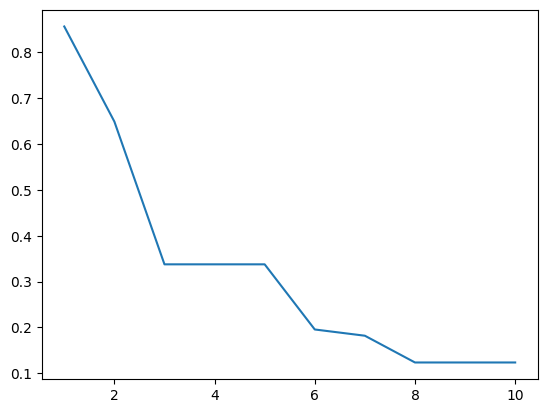

In [28]:
df_plot = df_training.query('bo_iteration>0')

x = df_plot['bo_iteration']
y = df_plot['loss'].cummin()

plt.plot(x, y)
#plt.legend(title='Parameter where:')
plt.show()

number of GT edges: 14
number of GT edges: 14
number of GT edges: 14
number of GT edges: 14
number of GT edges: 14
number of GT edges: 14
number of GT edges: 14
number of GT edges: 14
number of GT edges: 14
number of GT edges: 14


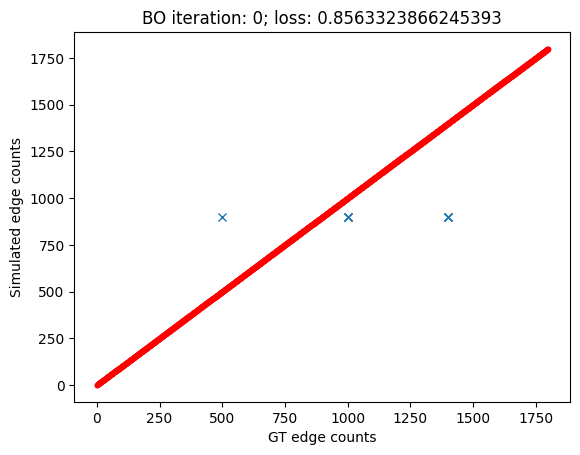

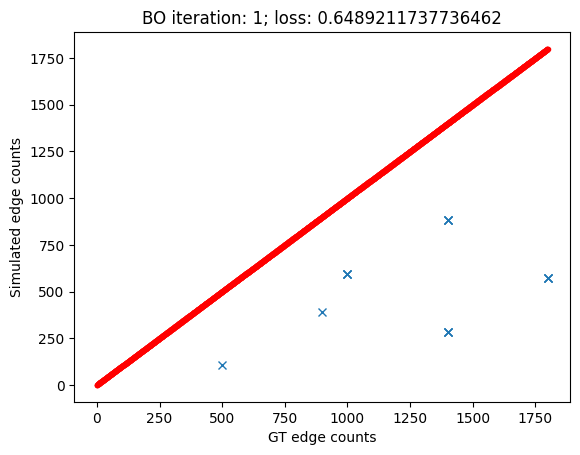

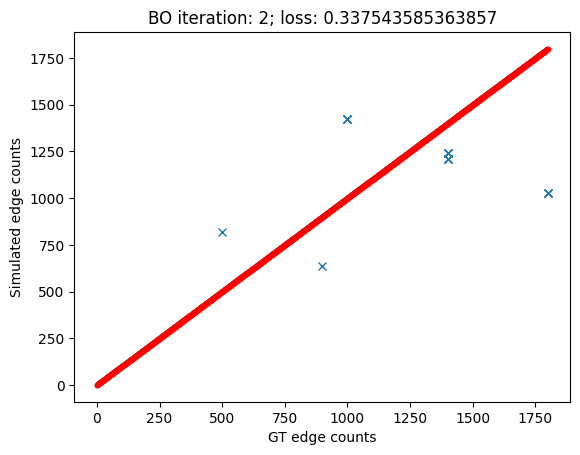

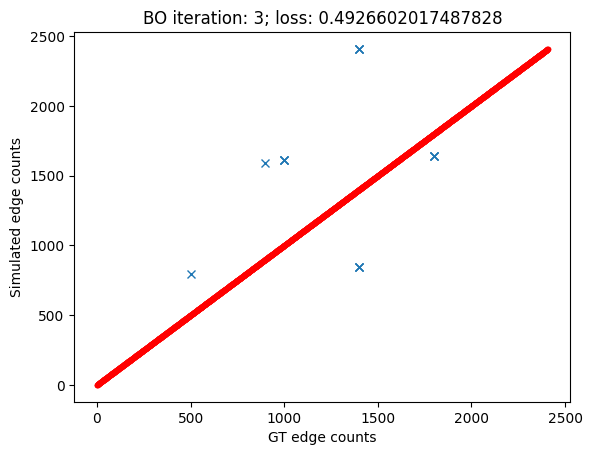

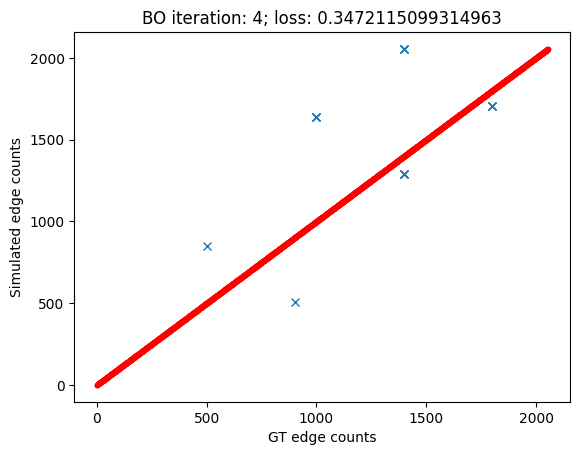

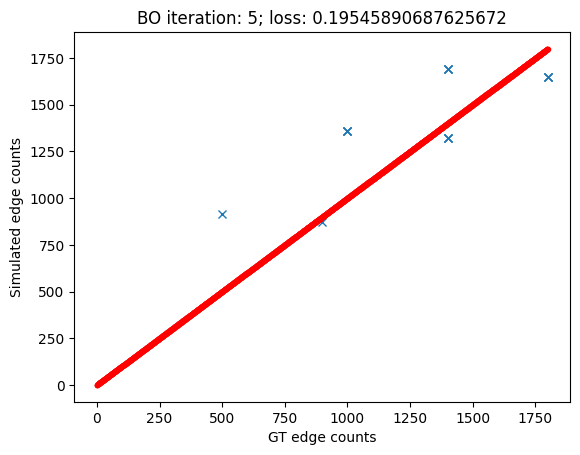

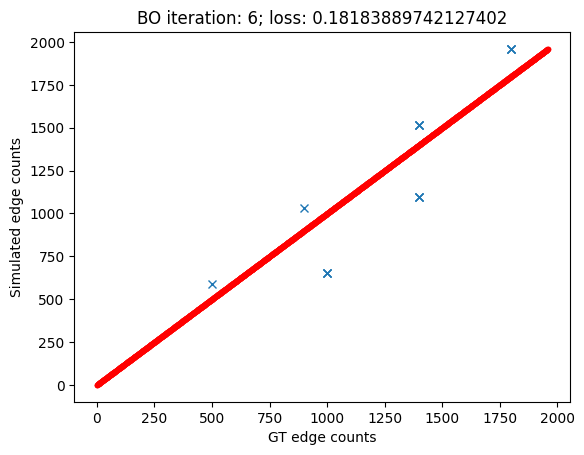

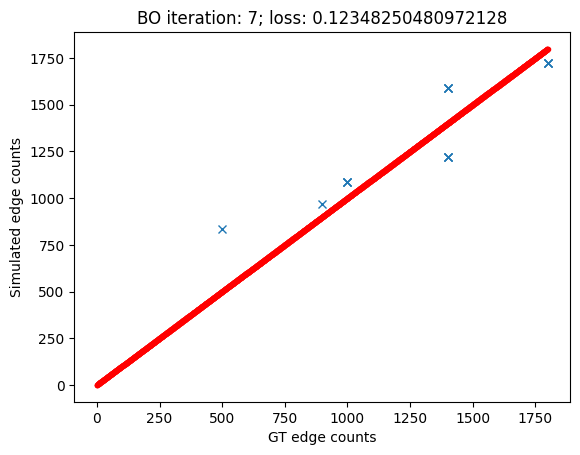

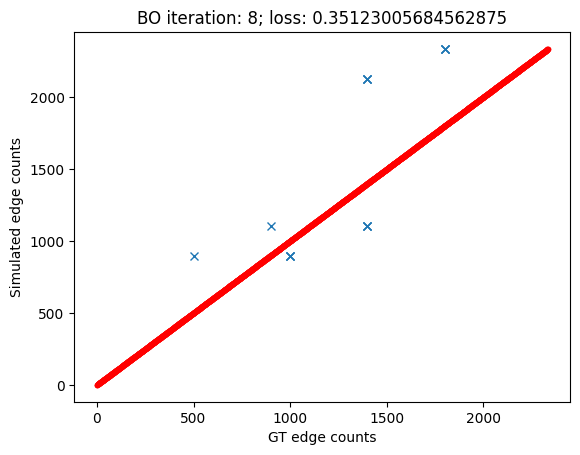

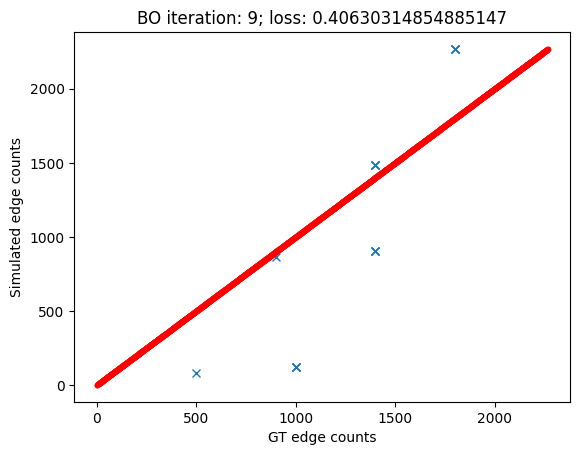

In [29]:
if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

for o1 in range(NITER): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    

    plt.figure()    
    plt.plot(df1b.interval_nVehContrib_gt, df1b.interval_nVehContrib_bo, 'x') 
    plt.title(f'BO iteration: {o1}; loss: {curr_loss}')
    plt.xlabel('GT edge counts') 
    plt.ylabel('Simulated edge counts') 
    
    # plotting diagonal line that represents a perfect data fit
    max_val = np.max([df1b.interval_nVehContrib_gt.max(), df1b.interval_nVehContrib_bo.max()])
    vec = np.arange(max_val)
    plt.plot(vec, vec, 'r.')


In [30]:
df_training.head()

,x_1,x_2,x_3,x_4,loss,bo_iteration
0,1865.265131,181.159094,1428.094387,1091.529727,0.860823,0
1,879.863679,1058.053970,326.977700,404.435515,0.527137,0
2,121.316478,769.173145,1654.914498,1942.880392,0.836649,0
3,1139.436960,1891.911864,599.779248,505.980551,0.865320,0
4,1289.055705,734.865010,27.929902,841.207385,0.523374,0
